# Training net for Homomorphic Encryption

## Contents
1. [Introduction](#Introduction)
1. [Setup](#Setup)
1. [Data](#Data)
1. [Training](#Training)
1. [Model weights](#Model-weights)

## Introduction

During this demo we will focus on homomorphic encryption. 

**Homomorphic encrypytion** is a form of encryption that allows computation on ciphertexts, generating an encrypted result which, when decrypted, matches the result of the operations as if they had been performed on the plaintext. This kind of encryption can be used for privacy-preserving outsourced storage and computation. Below there's an image explaining how does it work:


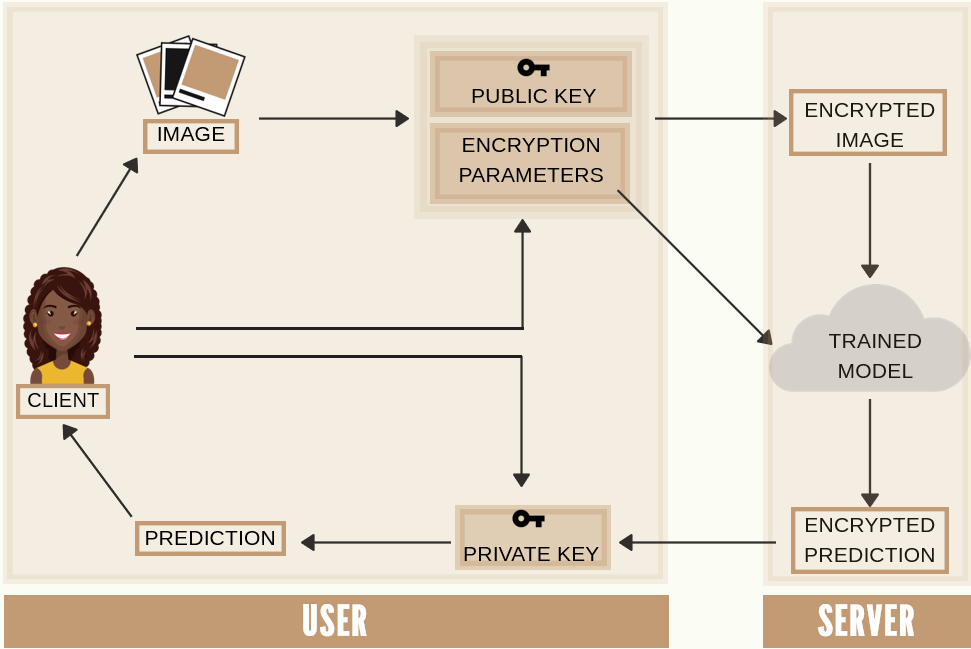

In this Jupyter notebook, what will be done is the training of a neural network to save its weight, which will be later used in the inference network which will have the same architecture but with the required modifications to use homomorphic encryption.

## Setup

### Import packages

In [1]:
from __future__ import division, print_function, absolute_import
import matplotlib.pyplot as plt 
import numpy as np
import os
%matplotlib inline
import sys
import tensorflow as tf

module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from services.storage.blob_storage import BlobStorageService
from settings import AZURE_STORAGE, DATA

## Data

A function to load the Fashion MNIST data is now defined:

In [ ]:
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load Fashion-MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

Now, the Fashion-MNIST data will be downloaded from an Azure Storage account.

In [2]:
storage = BlobStorageService(AZURE_STORAGE['STORAGE_ACCOUNT_NAME'], AZURE_STORAGE['STORAGE_ACCOUNT_KEY'])
blobs = storage.list_blobs(AZURE_STORAGE['CONTAINER'])

for blob in blobs:
    if 'data/fashion_mnist' in blob.name:
        storage.download_blob(AZURE_STORAGE['CONTAINER'], blob.name, '../../../' + blob.name)

### Data splitting
First, we need to split our data in train set and test set.

In [3]:
X_train, y_train_prior = load_mnist('../../' + DATA['FASHION_MNIST_PATH'], kind='train')
X_test, y_test_prior = load_mnist('../../' + DATA['FASHION_MNIST_PATH'], kind='t10k')

Once the data splitting is done, we do one hot encoder in the labels:

In [ ]:
y_train = np.zeros((len(y_train_prior),10))
y_train[np.arange(len(y_train_prior)), y_train_prior] = 1

y_test = np.zeros((len(y_test_prior),10))
y_test[np.arange(len(y_test_prior)), y_test_prior] = 1

## Training

First, we will define both the training and the network parameters:

In [4]:
# Training Parameters
learning_rate = 0.01
num_steps = 10000
batch_size = 120
display_step = 100

# Network Parameters
num_input = 784 # Fashion-MNIST data input (img shape: 28*28)
num_classes = 10 # Fashion-MNIST total classes (0-9 pieces of clothes)
dropout = 0.75 # Dropout, probability to keep units

# tf Graph input
X = tf.placeholder(tf.float32, [None, num_input])
Y = tf.placeholder(tf.float32, [None, num_classes])
keep_prob = tf.placeholder(tf.float32) # dropout (keep probability) 

### Build the neural network

In [5]:
def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return x

def meanpool2d(x, k=2):
    return tf.nn.avg_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],
                          padding='SAME')

# Create model
def conv_net(x, weights, biases, dropout):
    x = tf.reshape(x, shape=[-1, 28, 28, 1])

    # Convolution Layer
    conv1_ = conv2d(x, weights['wc1'], biases['bc1'])
    conv1_ = tf.square(conv1_)
    conv1 = meanpool2d(conv1_, k=2)
    
    conv2_ = conv2d(conv1, weights['wc2'], biases['bc2'])
    conv2 = meanpool2d(conv2_, k=2)
    
    fc1_ = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1_, weights['wd1']), biases['bd1'])
    fc1 = tf.square(fc1)
    # Dropout
    fc1_2 = tf.nn.dropout(fc1, dropout)
    
    check = {}
    check['conv1'] = conv1_
    check['conv1mp'] = conv1
    check['conv2'] = conv2_
    check['conv2mp'] = conv2
    check['fc1_reshape'] = fc1_
    check['fc1_wb'] = fc1
    check['fc1_drp'] = fc1_2

    # Output, class prediction
    out = tf.add(tf.matmul(fc1_2, weights['out']), biases['out'])
    return out, check

In [6]:
# Store layers weight & bias
weights = {
    # 5x5, 1 input, 5 outputs
    'wc1': tf.Variable(tf.random_normal([5, 5, 1, 5])),
    # 5x5, 5 inputs, 10 outputs
    'wc2': tf.Variable(tf.random_normal([5, 5, 5, 10])),
    # fully connected, 7x7x10 inputs, 128 outputs
    'wd1': tf.Variable(tf.random_normal([7*7*10, 128])),
    # 1024 inputs, 10 outputs 
    'out': tf.Variable(tf.random_normal([128, num_classes]))
}

biases = {
    'bc1': tf.Variable(tf.random_normal([5])),
    'bc2': tf.Variable(tf.random_normal([10])),
    'bd1': tf.Variable(tf.random_normal([128])),
    'out': tf.Variable(tf.random_normal([num_classes]))
}


# Build model
logits,verify = conv_net(X, weights, biases, keep_prob)
prediction = tf.nn.softmax(logits)

# Define loss and optimizer
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# Evaluate model
correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))


sess = tf.Session()
# Initialize 
init = tf.global_variables_initializer()
# Run the initializer
sess.run(init)

### Train the neural network

In [7]:
for step in range(1, num_steps+1):
        batch_x = X_train[(step-1)*batch_size:step*batch_size]
        batch_y = y_train[(step-1)*batch_size:step*batch_size]
        # batch_x, batch_y = mnist.train.next_batch(batch_size)
        # Run optimization op (backprop)
        sess.run(train_op, feed_dict={X: batch_x, Y: batch_y, keep_prob: dropout})
        if step % display_step == 0 or step == 1:
            # Calculate batch loss and accuracy
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: batch_x,
                                                                 Y: batch_y,
                                                                 keep_prob: 1.0})
            print("Step " + str(step) + ", Minibatch Loss= " + \
                  "{:.4f}".format(loss) + ", Training Accuracy= " + \
                  "{:.3f}".format(acc))

print("Optimization Finished!")

print("Testing Accuracy:", \
    sess.run(accuracy, feed_dict={X: X_test[:256],
                                  Y: y_test[:256],
                                  keep_prob: 1.0}))

Step 1, Minibatch Loss= 18512099319742464.0000, Training Accuracy= 0.225
Step 100, Minibatch Loss= 227433047392256.0000, Training Accuracy= 0.617
Step 200, Minibatch Loss= 123457173979136.0000, Training Accuracy= 0.625
Step 300, Minibatch Loss= 54591806767104.0000, Training Accuracy= 0.758
Step 400, Minibatch Loss= 56297185607680.0000, Training Accuracy= 0.750
Step 500, Minibatch Loss= 34917333336064.0000, Training Accuracy= 0.725
Step 600, Minibatch Loss= nan, Training Accuracy= nan
Step 700, Minibatch Loss= nan, Training Accuracy= nan
Step 800, Minibatch Loss= nan, Training Accuracy= nan
Step 900, Minibatch Loss= nan, Training Accuracy= nan
Step 1000, Minibatch Loss= nan, Training Accuracy= nan
Step 1100, Minibatch Loss= nan, Training Accuracy= nan
Step 1200, Minibatch Loss= nan, Training Accuracy= nan
Step 1300, Minibatch Loss= nan, Training Accuracy= nan
Step 1400, Minibatch Loss= nan, Training Accuracy= nan
Step 1500, Minibatch Loss= nan, Training Accuracy= nan
Step 1600, Minibatc

 ### Get a prediction

In [8]:
print(sess.run(logits, feed_dict={X: np.expand_dims(X_test[idx,:],0),keep_prob: 1.0}))

[[-6.8376014e+14 -4.8035283e+14  1.4396993e+15  7.6010536e+13
  -6.0716402e+14 -8.0117529e+12  2.9882050e+14 -9.1349472e+14
  -1.5840346e+14 -7.3424372e+14]]


Prediction: [9] Actual: 9


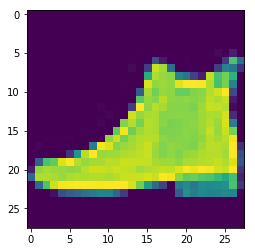

In [9]:
idx = 123 # change value to test different image
pred = sess.run(tf.argmax(prediction,1), feed_dict={X: np.expand_dims(X_test[idx,:],0),keep_prob: 1.0})
print ("Prediction:", pred, "Actual:",np.argmax(y_test[idx,:],-1))#tf.argmax(np.expand_dims(mnist.test.labels[1],0))#

plt.imshow(np.reshape(X_test[idx,:],(28,28)))

## Model weights

Once the model is trained, the weights are uploaded to the same Azure storage account to make them accessible to the inference network.

In [ ]:
weights_path =  'models/fashion_mnist/weights/'
biases_path = 'models/fashion_mnist/biases/'

np.save(os.path.join('../../../' + weights_path,'weights1.npy'),sess.run(weights['wc1']))
np.save(os.path.join('../../../' + weights_path,'weights2.npy'),sess.run(weights['wc2']))
np.save(os.path.join('../../../' + weights_path,'weights3.npy'),sess.run(weights['wd1']))
np.save(os.path.join('../../../' + weights_path,'weights4.npy'),sess.run(weights['out']))
np.save(os.path.join('../../../' + biases_path,'bc1.npy'),sess.run(biases['bc1']))
np.save(os.path.join('../../../' + biases_path,'bc2.npy'),sess.run(biases['bc2']))
np.save(os.path.join('../../../' + biases_path,'bd1.npy'),sess.run(biases['bd1']))
np.save(os.path.join('../../../' + biases_path,'bout.npy'),sess.run(biases['out']))

In [ ]:
storage.upload_directory(AZURE_STORAGE['CONTAINER'], '../../../' + weights_path, weights_path)
storage.upload_directory(AZURE_STORAGE['CONTAINER'], '../../../' + biases_path, biases_path)